In [1]:
import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LayerNormalization,Bidirectional,LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers


import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.utils.class_weight import compute_class_weight 

import pandas as pd
import pydot
import graphviz

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# MODEL 2-> UAR=0.583


NEURONS = 128
HIDDEN_LAYERS = 3
def create_DNN(input_shape, neurons = NEURONS, hidden_layers = HIDDEN_LAYERS, learning_rate = 0.0001, outputBais = None, verbose=0):
    if outputBais is not None:
        outputBais = tf.keras.initializers.Constant(outputBais)
    model = Sequential()

    model.add(Dense(128, input_dim=input_shape))
#     model.add(BatchNormalization())
    model.add(Activation("swish"))
    # model.add(Activation('relu'))
#     model.add(LayerNormalization())

    for i in range(hidden_layers-1):
        model.add(Dense(neurons))
#         model.add(BatchNormalization())
        model.add(Activation('swish'))


    

    model.add(Dense(5, bias_initializer = outputBais))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', "Recall"]) # categorical_crossentropy

    if verbose:
        model.summary()
    
    return model

In [4]:
# 讀取訓練資料集表單
source_df = pd.read_csv('./training datalist.csv')

print("source_df.shape :", source_df.shape)
print("source_df.columns :", source_df.columns)

source_df.shape : (1000, 28)
source_df.columns : Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10'],
      dtype='object')


In [5]:
def medical_data_proccessing(df):
    medical_col = ['Sex', 'Age', 'Narrow pitch range',
                'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
                'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
                'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
                'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
                'Head and Neck Cancer', 'Head injury', 'CVA',
                'Voice handicap index - 10', 'Disease category']
    
    # 選定要訓練預測的類別
    df = df.loc[df['Disease category'].isin([1, 2, 3, 4, 5]), medical_col]

    # 將性別編碼0,1
    df['Sex'] = df['Sex'] - 1

    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    df['Age'] = df['Age'] / 50
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'] / 40

    return df

In [6]:
source_df = medical_data_proccessing(source_df)

print("Disease category in training_df :", source_df['Disease category'].unique())
print("source_df col :", source_df.columns)
print("source_df shape :", source_df.shape)

Disease category in training_df : [1 2 3 5 4]
source_df col : Index(['Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10', 'Disease category'],
      dtype='object')
source_df shape : (1000, 27)


In [7]:
source_df

,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,Eye dryness,...,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,Disease category
0,1,0.78,1,1,1,1,1,0,0,0,...,3,1,0,0,0,0,0,0,0.550,1
1,0,1.38,1,1,1,1,0,0,1,0,...,1,3,0,0,0,0,0,1,0.475,2
2,1,1.18,1,1,1,1,0,0,1,0,...,3,4,0,0,0,0,0,0,0.450,2
3,1,0.94,1,0,1,1,1,0,0,0,...,1,1,0,0,0,0,0,0,0.675,1
4,0,1.74,0,0,0,0,0,0,0,0,...,1,4,0,1,0,0,0,0,0.400,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1.50,0,0,0,0,0,0,1,0,...,1,4,1,1,1,0,0,0,0.525,3
996,0,0.80,0,0,1,0,0,0,1,0,...,1,2,0,0,0,0,0,0,0.525,4
997,1,1.36,0,1,1,0,0,0,0,0,...,2,1,0,0,0,0,0,0,0.675,3
998,1,0.84,0,0,1,1,1,0,1,0,...,1,2,0,0,0,0,0,0,0.300,2


In [8]:
training_df, test_df = train_test_split(source_df, test_size=0.2, random_state=333)

print("training_df shape :", training_df.shape, ", test_df shape :", test_df.shape)

training_df shape : (800, 27) , test_df shape : (200, 27)


In [9]:
# 訓練資料標記轉換
training_data = training_df.iloc[:, :-1]
training_data['c1'] = training_df['Disease category'].map({1:1, 2:0, 3:0, 4:0, 5:0})
training_data['c2'] = training_df['Disease category'].map({1:0, 2:1, 3:0, 4:0, 5:0})
training_data['c3'] = training_df['Disease category'].map({1:0, 2:0, 3:1, 4:0, 5:0})
training_data['c4'] = training_df['Disease category'].map({1:0, 2:0, 3:0, 4:1, 5:0})
training_data['c5'] = training_df['Disease category'].map({1:0, 2:0, 3:0, 4:0, 5:1})


print("training_data.shape :", training_data.shape)

x_train = training_data.iloc[:, :-5]
y_train = training_data.iloc[:, -5:]
print("x_train.shape, y_train.shape :", x_train.shape, y_train.shape)
print("y_train.columns :", y_train.columns.tolist())

training_data.shape : (800, 31)
x_train.shape, y_train.shape : (800, 26) (800, 5)
y_train.columns : ['c1', 'c2', 'c3', 'c4', 'c5']


In [10]:
# 驗證資料標記轉換
test_data = test_df.iloc[:, :-1]
test_data['c1'] = test_df['Disease category'].map({1:1, 2:0, 3:0, 4:0, 5:0})
test_data['c2'] = test_df['Disease category'].map({1:0, 2:1, 3:0, 4:0, 5:0})
test_data['c3'] = test_df['Disease category'].map({1:0, 2:0, 3:1, 4:0, 5:0})
test_data['c4'] = test_df['Disease category'].map({1:0, 2:0, 3:0, 4:1, 5:0})
test_data['c5'] = test_df['Disease category'].map({1:0, 2:0, 3:0, 4:0, 5:1})

print("test_data.shape :", test_data.shape)

x_val = test_data.iloc[:, :-5]
y_val = test_data.iloc[:, -5:]
print("x_val.shape, y_val.shape :", x_val.shape, y_val.shape)
print("y_val.columns :", y_val.columns.tolist())

test_data.shape : (200, 31)
x_val.shape, y_val.shape : (200, 26) (200, 5)
y_val.columns : ['c1', 'c2', 'c3', 'c4', 'c5']


In [12]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / sum(y_train.c1))*(800)/5.0 
weight_for_1 = (1 / sum(y_train.c2))*(800)/5.0 
weight_for_2 = (1 / sum(y_train.c3))*(800)/5.0 
weight_for_3 = (1 / sum(y_train.c4))*(800)/5.0 
weight_for_4 = (1 / sum(y_train.c5))*(800)/5.0 

class_weights = {0: weight_for_0, 
                1: weight_for_1,
                2: weight_for_2,
                3: weight_for_3,
                4: weight_for_4}

outputBais = np.log([sum(y_train.c1)/(800-sum(y_train.c1)),
                       sum(y_train.c2)/(800-sum(y_train.c2)),
                       sum(y_train.c3)/(800-sum(y_train.c3)),
                       sum(y_train.c4)/(800-sum(y_train.c4)),
                       sum(y_train.c5)/(800-sum(y_train.c5))])

modelBais = create_DNN(input_shape = x_train.shape[1], verbose=0, outputBais=outputBais, learning_rate = 5e-4)
model = create_DNN(input_shape = x_train.shape[1], verbose=0, learning_rate = 5e-4)

In [13]:
class_weights

{0: 0.38186157517899766,
 1: 0.8743169398907105,
 2: 1.176470588235294,
 3: 4.848484848484849,
 4: 5.517241379310344}

In [14]:
# MODEL_SAVE_NAME = "modelBais"

BaisHistory = modelBais.fit(x_train, y_train, batch_size=128, epochs=150,
                            callbacks=[
                                # EarlyStopping(monitor='val_loss',
                                #               patience=10, mode='min'),
                                ModelCheckpoint(
                                    monitor='val_recall', mode='max', filepath="modelBais"+".h5", save_best_only=True)
                            ],
                            validation_data=(x_val, y_val),
                            class_weight=class_weights)

nonBaisHistory = model.fit(x_train, y_train, batch_size=128, epochs=150,
                           callbacks=[
                            #    EarlyStopping(monitor='val_loss',
                            #                  patience=10, mode='min'),
                               ModelCheckpoint(
                                   monitor='val_recall', mode='max', filepath="model"+".h5", save_best_only=True)
                           ],
                           validation_data=(x_val, y_val),
                           class_weight=class_weights)


Epoch 1/150
7/7 [==============================] - 1s 54ms/step - loss: 2.1573 - accuracy: 0.5238 - recall: 0.4387 - val_loss: 1.1740 - val_accuracy: 0.5800 - val_recall: 0.1100
Epoch 2/150
7/7 [==============================] - 0s 15ms/step - loss: 1.8448 - accuracy: 0.5175 - recall: 0.0350 - val_loss: 1.3128 - val_accuracy: 0.5100 - val_recall: 0.0050
Epoch 3/150
7/7 [==============================] - 0s 15ms/step - loss: 1.6391 - accuracy: 0.4313 - recall: 0.0012 - val_loss: 1.5081 - val_accuracy: 0.4050 - val_recall: 0.0000e+00
Epoch 4/150
7/7 [==============================] - 0s 15ms/step - loss: 1.5704 - accuracy: 0.3300 - recall: 0.0000e+00 - val_loss: 1.6454 - val_accuracy: 0.3500 - val_recall: 0.0000e+00
Epoch 5/150
7/7 [==============================] - 0s 15ms/step - loss: 1.5528 - accuracy: 0.2738 - recall: 0.0012 - val_loss: 1.5137 - val_accuracy: 0.3950 - val_recall: 0.0050
Epoch 6/150
7/7 [==============================] - 0s 14ms/step - loss: 1.5091 - accuracy: 0.4000 

Epoch 47/150
7/7 [==============================] - 0s 15ms/step - loss: 0.9581 - accuracy: 0.5362 - recall: 0.3713 - val_loss: 1.1325 - val_accuracy: 0.5600 - val_recall: 0.4000
Epoch 48/150
7/7 [==============================] - 0s 20ms/step - loss: 0.9481 - accuracy: 0.5750 - recall: 0.4100 - val_loss: 1.0274 - val_accuracy: 0.5950 - val_recall: 0.4700
Epoch 49/150
7/7 [==============================] - 0s 15ms/step - loss: 0.9437 - accuracy: 0.5800 - recall: 0.4325 - val_loss: 1.0774 - val_accuracy: 0.5900 - val_recall: 0.4500
Epoch 50/150
7/7 [==============================] - 0s 14ms/step - loss: 0.9375 - accuracy: 0.5750 - recall: 0.4375 - val_loss: 1.0588 - val_accuracy: 0.6150 - val_recall: 0.4550
Epoch 51/150
7/7 [==============================] - 0s 14ms/step - loss: 0.9295 - accuracy: 0.5825 - recall: 0.4363 - val_loss: 1.0765 - val_accuracy: 0.5850 - val_recall: 0.4600
Epoch 52/150
7/7 [==============================] - 0s 14ms/step - loss: 0.9220 - accuracy: 0.5763 - reca

Epoch 93/150
7/7 [==============================] - 0s 14ms/step - loss: 0.7793 - accuracy: 0.6400 - recall: 0.5375 - val_loss: 1.0505 - val_accuracy: 0.6550 - val_recall: 0.5400
Epoch 94/150
7/7 [==============================] - 0s 14ms/step - loss: 0.7529 - accuracy: 0.6175 - recall: 0.5250 - val_loss: 1.0732 - val_accuracy: 0.6200 - val_recall: 0.5300
Epoch 95/150
7/7 [==============================] - 0s 14ms/step - loss: 0.7756 - accuracy: 0.6313 - recall: 0.5387 - val_loss: 1.0826 - val_accuracy: 0.6500 - val_recall: 0.5400
Epoch 96/150
7/7 [==============================] - 0s 16ms/step - loss: 0.7473 - accuracy: 0.6112 - recall: 0.5100 - val_loss: 1.0756 - val_accuracy: 0.6250 - val_recall: 0.5400
Epoch 97/150
7/7 [==============================] - 0s 17ms/step - loss: 0.7466 - accuracy: 0.6388 - recall: 0.5325 - val_loss: 1.0496 - val_accuracy: 0.6450 - val_recall: 0.5400
Epoch 98/150
7/7 [==============================] - 0s 14ms/step - loss: 0.7634 - accuracy: 0.6075 - reca

7/7 [==============================] - 0s 15ms/step - loss: 0.6295 - accuracy: 0.6812 - recall: 0.6150 - val_loss: 1.2478 - val_accuracy: 0.5950 - val_recall: 0.5150
Epoch 139/150
7/7 [==============================] - 0s 14ms/step - loss: 0.6475 - accuracy: 0.6137 - recall: 0.5362 - val_loss: 1.1210 - val_accuracy: 0.6500 - val_recall: 0.5650
Epoch 140/150
7/7 [==============================] - 0s 14ms/step - loss: 0.6337 - accuracy: 0.6862 - recall: 0.6025 - val_loss: 1.1781 - val_accuracy: 0.6050 - val_recall: 0.5300
Epoch 141/150
7/7 [==============================] - 0s 13ms/step - loss: 0.6187 - accuracy: 0.6538 - recall: 0.5838 - val_loss: 1.1334 - val_accuracy: 0.6450 - val_recall: 0.5750
Epoch 142/150
7/7 [==============================] - 0s 15ms/step - loss: 0.6152 - accuracy: 0.6812 - recall: 0.5987 - val_loss: 1.2044 - val_accuracy: 0.6250 - val_recall: 0.5200
Epoch 143/150
7/7 [==============================] - 0s 15ms/step - loss: 0.6130 - accuracy: 0.6538 - recall: 0.57

7/7 [==============================] - 0s 15ms/step - loss: 1.0210 - accuracy: 0.5175 - recall: 0.3338 - val_loss: 1.1348 - val_accuracy: 0.5500 - val_recall: 0.3550
Epoch 34/150
7/7 [==============================] - 0s 14ms/step - loss: 1.0104 - accuracy: 0.5200 - recall: 0.3300 - val_loss: 1.1449 - val_accuracy: 0.5350 - val_recall: 0.3500
Epoch 35/150
7/7 [==============================] - 0s 19ms/step - loss: 1.0188 - accuracy: 0.5375 - recall: 0.3650 - val_loss: 1.0820 - val_accuracy: 0.5700 - val_recall: 0.4100
Epoch 36/150
7/7 [==============================] - 0s 14ms/step - loss: 1.0032 - accuracy: 0.5175 - recall: 0.3400 - val_loss: 1.1737 - val_accuracy: 0.4950 - val_recall: 0.2950
Epoch 37/150
7/7 [==============================] - 0s 15ms/step - loss: 0.9954 - accuracy: 0.5188 - recall: 0.3325 - val_loss: 1.1210 - val_accuracy: 0.5450 - val_recall: 0.3700
Epoch 38/150
7/7 [==============================] - 0s 14ms/step - loss: 0.9928 - accuracy: 0.5312 - recall: 0.3600 - 

Epoch 79/150
7/7 [==============================] - 0s 15ms/step - loss: 0.8448 - accuracy: 0.5475 - recall: 0.4437 - val_loss: 1.0450 - val_accuracy: 0.6250 - val_recall: 0.5050
Epoch 80/150
7/7 [==============================] - 0s 16ms/step - loss: 0.8262 - accuracy: 0.6062 - recall: 0.5125 - val_loss: 1.0409 - val_accuracy: 0.5950 - val_recall: 0.5100
Epoch 81/150
7/7 [==============================] - 0s 16ms/step - loss: 0.8211 - accuracy: 0.5725 - recall: 0.4625 - val_loss: 1.1181 - val_accuracy: 0.5950 - val_recall: 0.4800
Epoch 82/150
7/7 [==============================] - 0s 15ms/step - loss: 0.8150 - accuracy: 0.5925 - recall: 0.4913 - val_loss: 1.0555 - val_accuracy: 0.6050 - val_recall: 0.5000
Epoch 83/150
7/7 [==============================] - 0s 14ms/step - loss: 0.8012 - accuracy: 0.5838 - recall: 0.4775 - val_loss: 1.1149 - val_accuracy: 0.6000 - val_recall: 0.4700
Epoch 84/150
7/7 [==============================] - 0s 14ms/step - loss: 0.7943 - accuracy: 0.5987 - reca

Epoch 125/150
7/7 [==============================] - 0s 15ms/step - loss: 0.6617 - accuracy: 0.6488 - recall: 0.5638 - val_loss: 1.1400 - val_accuracy: 0.6050 - val_recall: 0.5300
Epoch 126/150
7/7 [==============================] - 0s 19ms/step - loss: 0.6683 - accuracy: 0.6200 - recall: 0.5425 - val_loss: 1.0478 - val_accuracy: 0.6400 - val_recall: 0.5800
Epoch 127/150
7/7 [==============================] - 0s 15ms/step - loss: 0.6724 - accuracy: 0.6712 - recall: 0.5913 - val_loss: 1.1475 - val_accuracy: 0.6150 - val_recall: 0.5400
Epoch 128/150
7/7 [==============================] - 0s 13ms/step - loss: 0.6581 - accuracy: 0.6450 - recall: 0.5537 - val_loss: 1.1323 - val_accuracy: 0.6100 - val_recall: 0.5500
Epoch 129/150
7/7 [==============================] - 0s 15ms/step - loss: 0.6555 - accuracy: 0.6350 - recall: 0.5525 - val_loss: 1.0759 - val_accuracy: 0.6500 - val_recall: 0.5550
Epoch 130/150
7/7 [==============================] - 0s 16ms/step - loss: 0.6499 - accuracy: 0.6587 

In [15]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()

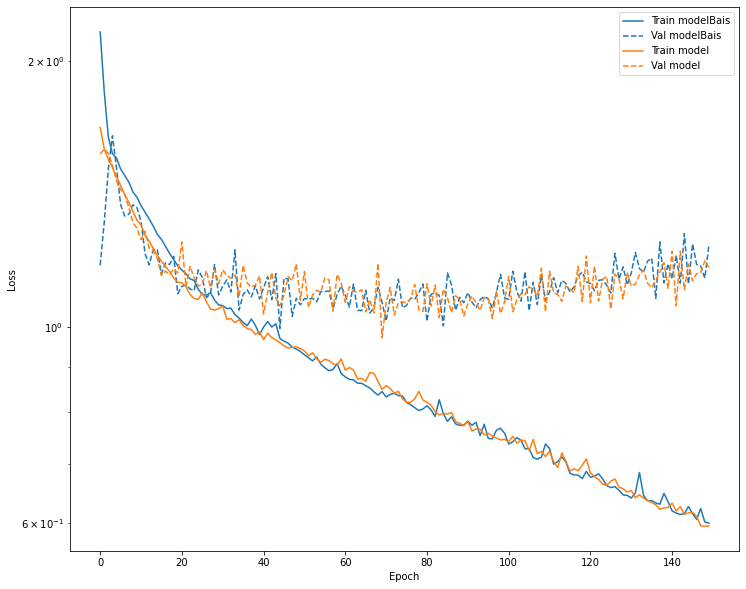

In [16]:
plot_loss(BaisHistory, 'modelBais', 0)
plot_loss(nonBaisHistory, 'model', 1)

25/25 [==============================] - 0s 2ms/step
Training UAR(Unweighted Average Recall) : 0.7999474101580516


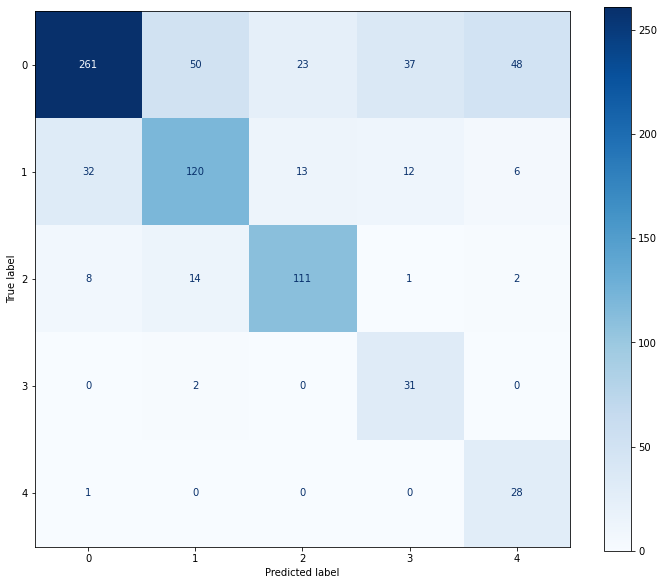

In [17]:
y_pred = model.predict(training_df.iloc[:, :-1]).argmax(axis=1)
y_true = training_df['Disease category'] - 1

results_recall = recall_score(y_true, y_pred, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

In [18]:
def testUAR(model):
    y_pred = model.predict(test_df.iloc[:, :-1]).argmax(axis=1)
    y_true = test_df['Disease category'] - 1
    
    results_recall = recall_score(y_true, y_pred, average=None)
    print("Test UAR(Unweighted Average Recall) :", results_recall.mean())
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

7/7 [==============================] - 0s 2ms/step
Test UAR(Unweighted Average Recall) : 0.5194556007056007


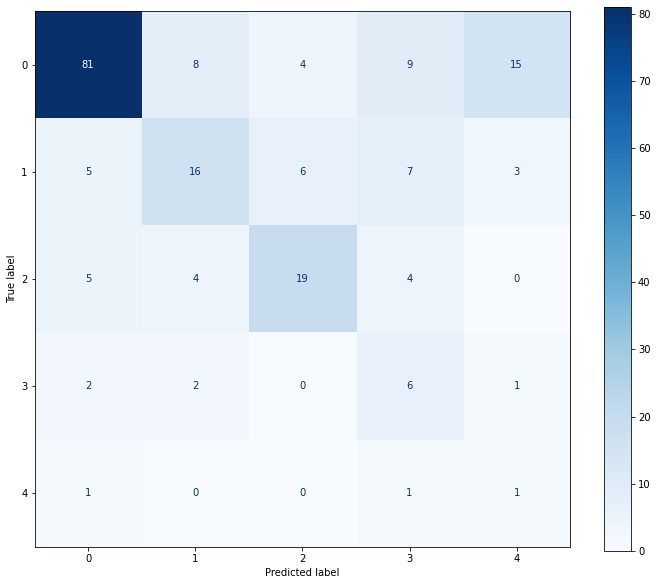

In [19]:
testUAR(model)

7/7 [==============================] - 0s 2ms/step
Test UAR(Unweighted Average Recall) : 0.5322125884625885


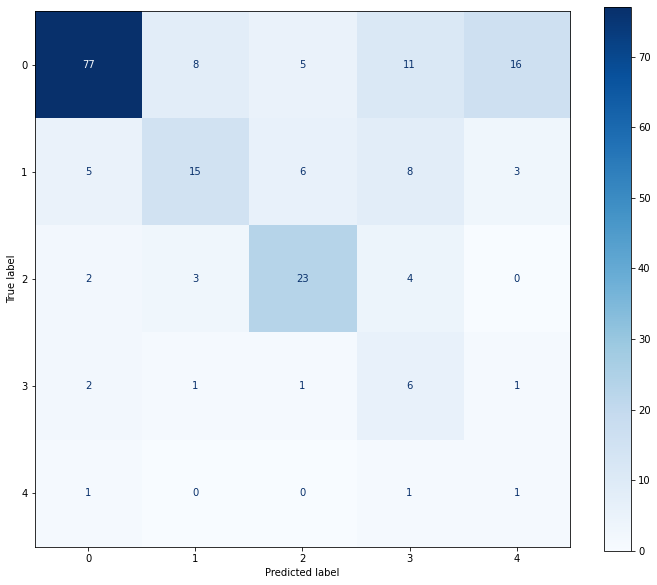

In [20]:
testUAR(modelBais)

In [21]:
model.load_weights("./model.h5")
modelBais.load_weights("./modelBais.h5")

7/7 [==============================] - 0s 2ms/step
Test UAR(Unweighted Average Recall) : 0.5115301927801928


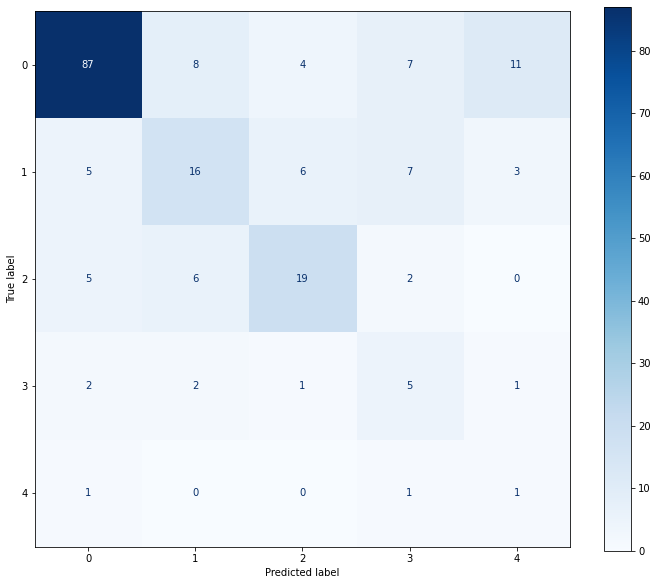

In [22]:
testUAR(model)

In [23]:
from keras.models import load_model
models=[]

model1=tf.keras.models.load_model("./0.538modelBais.h5")
model1._name="model1"

model2=tf.keras.models.load_model("./0.540model.h5")
model2._name="model2"

model3=tf.keras.models.load_model("./0.5824modelBais.h5")
model3._name="model3"

model4=tf.keras.models.load_model("./0.5869model.h5")
model4._name="model4"

model5=tf.keras.models.load_model("./0.5872model.h5")
model5._name="model5"

model6=tf.keras.models.load_model("./0.587modelBais.h5")
model6._name="model6"

model7=tf.keras.models.load_model("./0.5892modelBais.h5")
model7._name="model7"

model8=tf.keras.models.load_model("./0.594model.h5")
model8._name="model8"

model9=tf.keras.models.load_model("./0.5994modelBais.h5")
model9._name="model9"

model10=tf.keras.models.load_model("./0.6model.h5")
model10._name="model10"


models.append(model1)
models.append(model2)
models.append(model3)
models.append(model4)
models.append(model5)
models.append(model6)
models.append(model7)
models.append(model8)
models.append(model9)
models.append(model10)


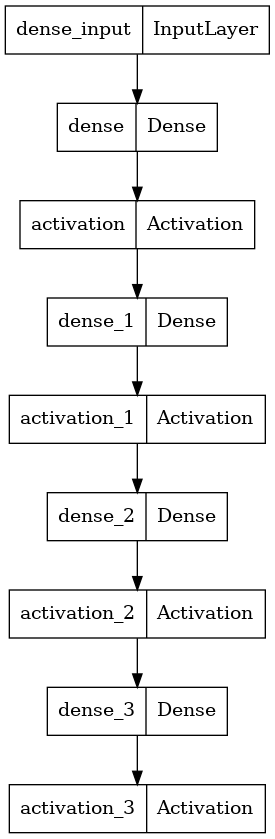

In [24]:
tf.keras.utils.plot_model(model1)

In [25]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=tf.keras.layers.average(yModels) 
    # build model from same input and avg output
    modelEns = tf.keras.Model(inputs=model_input, outputs=yAvg,    name='ensemble')  
   
    return modelEns

In [26]:
model_input = tf.keras.Input(shape=models[0].input_shape[1:]) # c*h*w
modelEns = ensembleModels(models, model_input)
modelEns.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 model1 (Sequential)            (None, 5)            37125       ['input_1[0][0]']                
                                                                                                  
 model2 (Sequential)            (None, 5)            37125       ['input_1[0][0]']                
                                                                                                  
 model3 (Sequential)            (None, 5)            37125       ['input_1[0][0]']                
                                                                                           

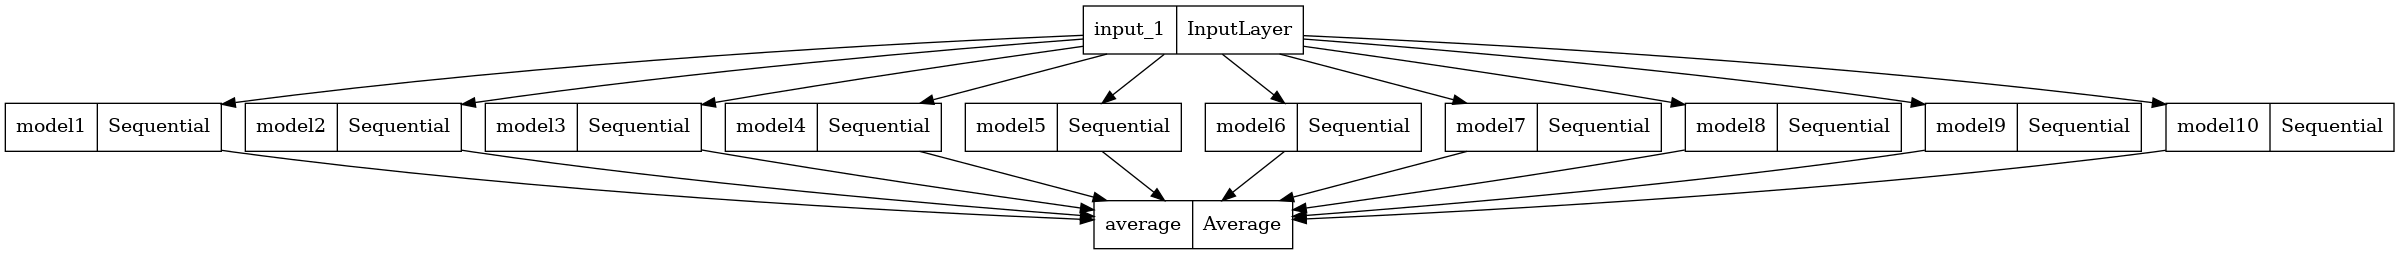

In [27]:
from keras.utils import plot_model
tf.keras.utils.plot_model(modelEns)

In [28]:
models[0].input_shape[1:]

(26,)

In [37]:
test_dataset=pd.read_csv("./test_datalist_public.csv")
ID=test_dataset["ID"]

In [38]:
ID

0      1301skj
1      1100j0u
2      0G00r5c
3      1202v5m
4      0C01365
        ...   
495    0C0147g
496    13021ib
497    110049h
498    0T01khc
499    0C02cr3
Name: ID, Length: 500, dtype: object

In [39]:
def public_test_medical_data_proccessing(df):
    medical_col = ['Sex', 'Age', 'Narrow pitch range',
                'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
                'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
                'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
                'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
                'Head and Neck Cancer', 'Head injury', 'CVA',
                'Voice handicap index - 10']
    
    # 選定要訓練預測的類別
#     f = df.loc[df['Disease category'].isin([1, 2, 3, 4, 5]), medical_col]
#     df = df.loc[df['Sex'], medical_col]
    df = df[medical_col]

    # 將性別編碼0,1
    df['Sex'] = df['Sex'] - 1

    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    df['Age'] = df['Age'] / 50
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'] / 40

    return df

In [40]:
test_dataset = public_test_medical_data_proccessing(test_dataset)

/tmp/ipykernel_5366/4095941813.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sex'] = df['Sex'] - 1
/tmp/ipykernel_5366/4095941813.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PPD'] = df['PPD'].fillna(0)
/tmp/ipykernel_5366/4095941813.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [41]:
test_dataset

,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,Eye dryness,...,Onset of dysphonia,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10
0,1,0.54,0,1,1,1,1,0,0,0,...,2,3,1,0,0,0,0,0,0,0.750
1,0,1.00,0,0,0,0,0,0,0,0,...,1,2,2,0,1,0,0,0,0,0.750
2,0,0.82,1,1,0,0,0,0,0,1,...,5,2,3,0,0,0,0,0,0,0.725
3,1,0.96,1,0,0,1,1,0,0,0,...,2,1,4,0,0,0,0,0,0,0.125
4,1,0.86,0,1,0,1,0,1,1,0,...,1,2,1,0,0,1,0,0,0,0.675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0.78,1,0,0,0,0,0,0,1,...,2,2,2,0,0,0,0,0,0,0.750
496,1,1.16,0,0,1,1,0,1,0,0,...,2,3,1,0,0,0,0,0,0,0.750
497,0,1.44,0,1,1,0,0,0,0,0,...,3,1,3,0,1,0,0,0,0,0.800
498,1,1.20,1,0,0,0,1,0,0,0,...,2,2,4,0,0,0,1,0,0,0.075


In [42]:
pred = np.argmax(modelEns.predict(test_dataset.values),axis=1)

16/16 [==============================] - 0s 7ms/step


In [43]:
prepare_dataframe=pd.DataFrame({"ID":ID,"Category":pred+1})

In [44]:
prepare_dataframe

,ID,Category
0,1301skj,1
1,1100j0u,4
2,0G00r5c,2
3,1202v5m,1
4,0C01365,3
...,...,...
495,0C0147g,1
496,13021ib,1
497,110049h,2
498,0T01khc,2


In [45]:
prepare_dataframe.to_csv("./out.csv")

In [ ]:
#################################################

In [ ]:
#Private

In [46]:
test_dataset=pd.read_csv("./test_datalist_private.csv")
ID=test_dataset["ID"]

In [47]:
test_dataset

,ID,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,...,Onset of dysphonia,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10
0,0U02g8u,2,77,0,1,0,1,0,0,0,...,3,1,3,1,1,0,0,0,1,14.0
1,0Y00jid,2,68,0,0,1,1,1,0,1,...,2,1,4,0,0,0,0,0,0,8.0
2,0R02296,1,38,0,1,0,1,1,0,0,...,3,2,1,0,0,0,1,0,0,25.0
3,0W016c9,1,58,0,1,1,0,1,0,0,...,3,1,3,0,1,0,0,0,0,34.0
4,11006gd,2,75,0,1,1,0,1,0,0,...,2,1,3,1,1,0,0,0,0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1001abu,2,29,1,1,1,0,0,0,0,...,1,2,1,0,0,0,0,0,0,39.0
496,1002ss4,2,77,1,1,0,0,0,0,0,...,2,1,2,0,0,0,0,0,0,21.0
497,0W011bi,1,44,0,1,1,1,1,1,0,...,3,1,1,0,0,0,0,0,0,27.0
498,0R00num,1,63,0,0,1,1,0,0,1,...,2,2,2,0,0,0,0,0,0,40.0


In [48]:
def public_test_medical_data_proccessing(df):
    medical_col = ['Sex', 'Age', 'Narrow pitch range',
                'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
                'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
                'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
                'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
                'Head and Neck Cancer', 'Head injury', 'CVA',
                'Voice handicap index - 10']
    
    # 選定要訓練預測的類別
#     f = df.loc[df['Disease category'].isin([1, 2, 3, 4, 5]), medical_col]
#     df = df.loc[df['Sex'], medical_col]
    df = df[medical_col]

    # 將性別編碼0,1
    df['Sex'] = df['Sex'] - 1

    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    df['Age'] = df['Age'] / 50
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'] / 40

    return df

In [49]:
test_dataset = public_test_medical_data_proccessing(test_dataset)

/tmp/ipykernel_5366/4095941813.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sex'] = df['Sex'] - 1
/tmp/ipykernel_5366/4095941813.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PPD'] = df['PPD'].fillna(0)
/tmp/ipykernel_5366/4095941813.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [50]:
pred = np.argmax(modelEns.predict(test_dataset.values),axis=1)

16/16 [==============================] - 0s 8ms/step


In [51]:
pred+1

array([2, 2, 3, 4, 2, 1, 2, 1, 1, 1, 5, 3, 1, 3, 2, 2, 1, 2, 1, 1, 3, 1,
       1, 1, 2, 1, 3, 2, 1, 1, 3, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 4,
       1, 1, 3, 2, 3, 3, 2, 1, 4, 2, 1, 2, 1, 2, 1, 5, 1, 1, 5, 5, 1, 1,
       1, 1, 3, 4, 3, 3, 1, 1, 1, 2, 1, 1, 4, 2, 1, 4, 3, 5, 1, 3, 5, 5,
       2, 5, 5, 5, 1, 1, 4, 5, 1, 1, 2, 3, 1, 4, 4, 3, 4, 2, 1, 3, 3, 1,
       2, 1, 4, 3, 2, 2, 2, 3, 5, 3, 1, 4, 4, 2, 4, 1, 2, 2, 1, 4, 3, 1,
       4, 1, 5, 2, 5, 3, 3, 1, 1, 2, 1, 1, 2, 2, 5, 1, 1, 1, 1, 3, 1, 4,
       2, 2, 1, 1, 1, 1, 3, 3, 5, 4, 4, 2, 1, 2, 1, 2, 1, 1, 1, 5, 1, 3,
       3, 1, 1, 2, 3, 4, 4, 5, 2, 4, 5, 4, 1, 4, 4, 1, 3, 1, 2, 2, 2, 2,
       1, 4, 4, 4, 1, 5, 1, 1, 1, 3, 5, 2, 2, 2, 1, 4, 3, 1, 1, 3, 3, 4,
       4, 1, 1, 3, 1, 5, 3, 1, 2, 2, 2, 3, 3, 5, 3, 4, 1, 1, 2, 5, 4, 3,
       1, 4, 1, 4, 5, 1, 2, 1, 2, 3, 1, 2, 1, 1, 3, 1, 4, 3, 2, 2, 3, 1,
       2, 3, 1, 1, 2, 2, 1, 5, 5, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       3, 4, 5, 4, 1, 1, 2, 1, 1, 1, 5, 1, 3, 3, 5,

In [52]:
prepare_dataframe=pd.DataFrame({"ID":ID,"Category":pred+1})

In [53]:
prepare_dataframe

,ID,Category
0,0U02g8u,2
1,0Y00jid,2
2,0R02296,3
3,0W016c9,4
4,11006gd,2
...,...,...
495,1001abu,1
496,1002ss4,2
497,0W011bi,4
498,0R00num,4


In [54]:
prepare_dataframe.to_csv("./test_out.csv")